In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
# nltk.download('all')
# nltk.download('punkt')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from surprise import SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

C:\Users\ARYAN\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# !pip install missingno

In [3]:
arxivData = pd.read_csv('author_coauher.csv')

In [4]:
arxivData.head()

Unnamed: 0  user_id  author_id              author  \
0           0        1       1000      Wolfgang Bibel   
1           1        2       1001  Jean-Marie Nicolas   
2           2        3       1002             D. Chan   
3           3        4       1003          M. Wallace   
4           4        5       1004       J. C. Freytag   

                                               title  year  \
0  Dual Recurrent Attention Units for Visual Ques...  1989   
1  Sequential Short-Text Classification with Recu...  1989   
2  Multiresolution Recurrent Neural Networks: An ...  1989   
3  Learning what to share between loosely related...  1988   
4              A Deep Reinforcement Learning Chatbot  1988   

                                            abstract           co_author  \
0  When two or more distinct organizations interc...  Jean-Marie Nicolas   
1  Hosts are under EMCON condition, short for Emi...         J. B. Bocca   
2  In distributed systems surveillance protocols ...          M. Wallace   
3  The Versatile Message Transaction Protocol (VM...       J. C. Freytag   
4  The paper is concerned with efficient implemen...         J. B. Bocca   

   coauthor_id  title_id  
0         1001        83  
1         1005        49  
2         1003        21  
3         1004        57  
4         1005        57

In [5]:
arxivData.columns

Index(['Unnamed: 0', 'user_id', 'author_id', 'author', 'title', 'year',
       'abstract', 'co_author', 'coauthor_id', 'title_id'],
      dtype='object')

In [6]:
#dropping irrelevant columns
columns_to_delete = ['Unnamed: 0']
arxivData.drop(columns_to_delete, inplace=True, axis=1)

In [7]:
arxivData.head()

user_id  author_id              author  \
0        1       1000      Wolfgang Bibel   
1        2       1001  Jean-Marie Nicolas   
2        3       1002             D. Chan   
3        4       1003          M. Wallace   
4        5       1004       J. C. Freytag   

                                               title  year  \
0  Dual Recurrent Attention Units for Visual Ques...  1989   
1  Sequential Short-Text Classification with Recu...  1989   
2  Multiresolution Recurrent Neural Networks: An ...  1989   
3  Learning what to share between loosely related...  1988   
4              A Deep Reinforcement Learning Chatbot  1988   

                                            abstract           co_author  \
0  When two or more distinct organizations interc...  Jean-Marie Nicolas   
1  Hosts are under EMCON condition, short for Emi...         J. B. Bocca   
2  In distributed systems surveillance protocols ...          M. Wallace   
3  The Versatile Message Transaction Protocol (VM...       J. C. Freytag   
4  The paper is concerned with efficient implemen...         J. B. Bocca   

   coauthor_id  title_id  
0         1001        83  
1         1005        49  
2         1003        21  
3         1004        57  
4         1005        57

In [8]:
arxivData.shape

(152, 9)

In [9]:
# Data Cleaning
def clean_text(text):
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", " ", text)
    # remove whitespaces
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [10]:
# creating clean text feature
features = ['title', 'abstract']
for feature in features:
    arxivData['clean_' + feature] = arxivData[feature].apply(clean_text)

In [11]:
arxivData.head()

user_id  author_id              author  \
0        1       1000      Wolfgang Bibel   
1        2       1001  Jean-Marie Nicolas   
2        3       1002             D. Chan   
3        4       1003          M. Wallace   
4        5       1004       J. C. Freytag   

                                               title  year  \
0  Dual Recurrent Attention Units for Visual Ques...  1989   
1  Sequential Short-Text Classification with Recu...  1989   
2  Multiresolution Recurrent Neural Networks: An ...  1989   
3  Learning what to share between loosely related...  1988   
4              A Deep Reinforcement Learning Chatbot  1988   

                                            abstract           co_author  \
0  When two or more distinct organizations interc...  Jean-Marie Nicolas   
1  Hosts are under EMCON condition, short for Emi...         J. B. Bocca   
2  In distributed systems surveillance protocols ...          M. Wallace   
3  The Versatile Message Transaction Protocol (VM...       J. C. Freytag   
4  The paper is concerned with efficient implemen...         J. B. Bocca   

   coauthor_id  title_id                                        clean_title  \
0         1001        83  dual recurrent attention units for visual ques...   
1         1005        49  sequential short text classification with recu...   
2         1003        21  multiresolution recurrent neural networks an a...   
3         1004        57  learning what to share between loosely related...   
4         1005        57              a deep reinforcement learning chatbot   

                                      clean_abstract  
0  when two or more distinct organizations interc...  
1  hosts are under emcon condition short for emis...  
2  in distributed systems surveillance protocols ...  
3  the versatile message transaction protocol vmt...  
4  the paper is concerned with efficient implemen...

In [12]:
arxivData['soup'] = arxivData['clean_title'] + arxivData['clean_abstract']

In [13]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

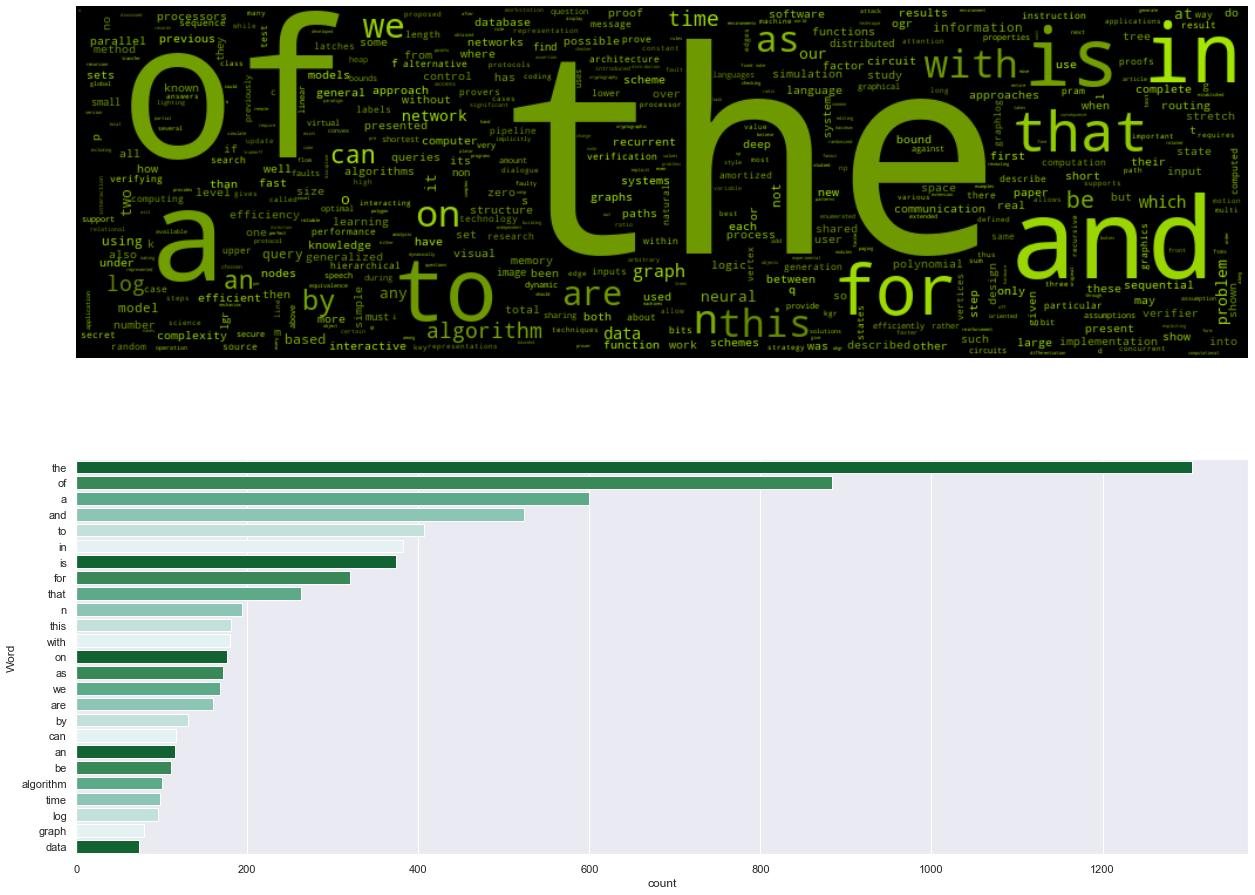

In [14]:
# plot 25 most frequent words including stop words
freq_words(arxivData['soup'], 25)

In [15]:
# stopwords-to compare text data with and without stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
arxivData['soup'] = arxivData['soup'].apply(lambda x: remove_stopwords(x))

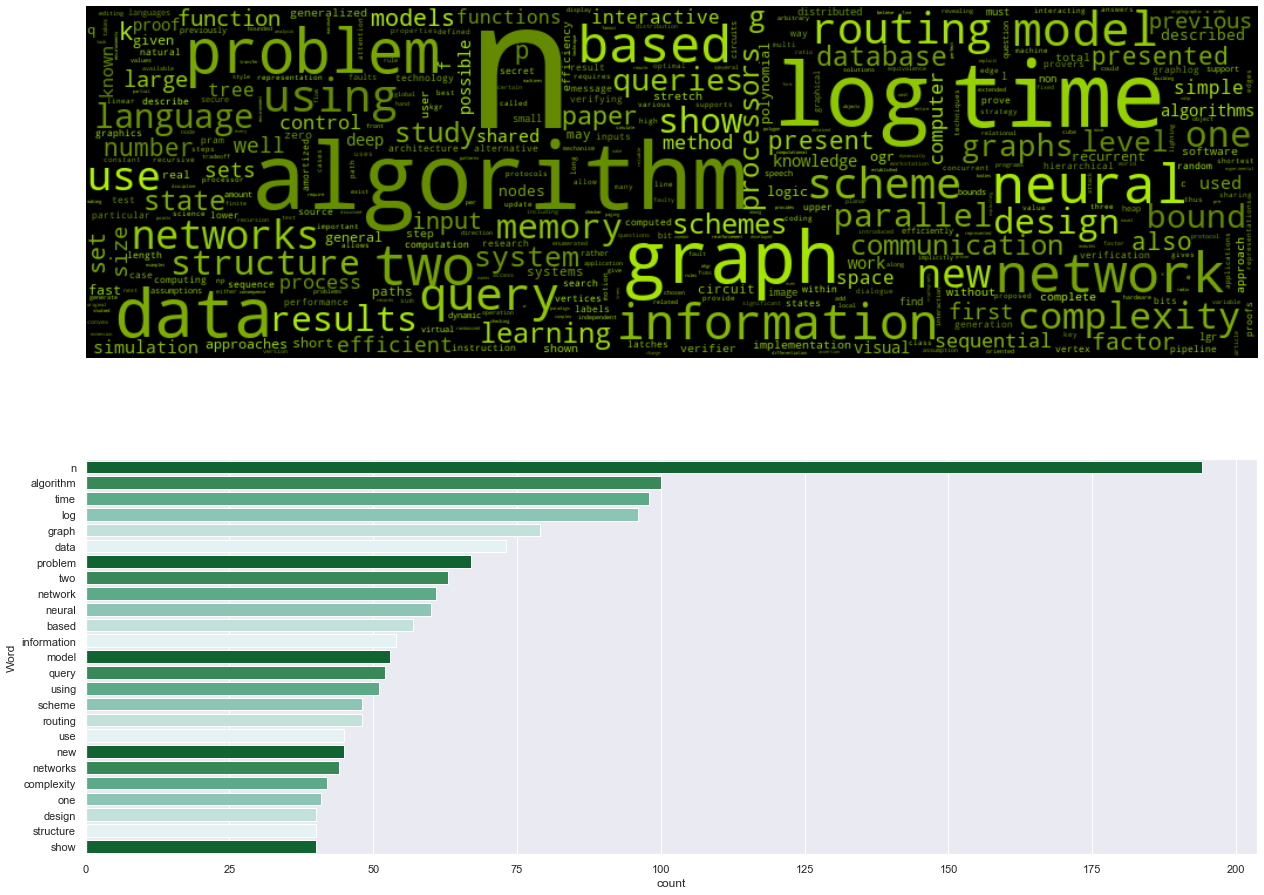

In [16]:
# plot 25 most frequent words without stopwords
freq_words(arxivData['soup'], 25)

In [17]:
arxivData[['year']].head()

year
0  1989
1  1989
2  1989
3  1988
4  1988

In [18]:
# Lemmatization process
'''
Words in the third person are changed to first person and verbs in past and future tenses are changed into the present by the 
lemmatization process. 
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

In [19]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)

In [20]:
arxivData.columns

Index(['user_id', 'author_id', 'author', 'title', 'year', 'abstract',
       'co_author', 'coauthor_id', 'title_id', 'clean_title', 'clean_abstract',
       'soup'],
      dtype='object')

In [21]:
len(arxivData['soup'])

152

## Recommender based on summary

In [22]:
arxivData['clean_abstract'].head()

0    when two or more distinct organizations interc...
1    hosts are under emcon condition short for emis...
2    in distributed systems surveillance protocols ...
3    the versatile message transaction protocol vmt...
4    the paper is concerned with efficient implemen...
Name: clean_abstract, dtype: object

In [23]:
arxivData['co_author'].head()

0    Jean-Marie Nicolas
1           J. B. Bocca
2            M. Wallace
3         J. C. Freytag
4           J. B. Bocca
Name: co_author, dtype: object

In [24]:
# TfIdf matrix transformation on clean_summary column
tfidf_matrix = tfidf_vec.fit_transform(arxivData['co_author'])
# Compute the cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [25]:
import random
import sklearn
from sklearn.metrics import mean_squared_error
actual = list(arxivData['co_author'])
predicted = random.sample(actual, len(actual))

In [26]:
# TfIdf matrix transformation on clean_summary column
tfidf_matrix = tfidf_vec.fit_transform(predicted)
# Compute the cosine similarity
pred_cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
pred_cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
cosine_mse = sklearn.metrics.mean_squared_error(cosine_sim, pred_cosine_sim)
cosine_mse

0.039803940741139326

In [28]:
import math
cosine_rmse = math.sqrt(cosine_mse)
cosine_rmse

0.1995092497633614

In [29]:
indices = pd.Series(arxivData.index, index=arxivData['title']).drop_duplicates()

In [30]:
def get_recommendations(title, similarity):
    
    idx = indices[title]
    print(idx)
    # pairwsie similarity scores
    sim_scores = list(enumerate(similarity[idx]))
    # sorting
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    article_indices = [i[0] for i in sim_scores]
    # Return the top 10 most related articles
    return arxivData[['author', 'title', 'co_author']].iloc[article_indices]

In [31]:
indices

title
Dual Recurrent Attention Units for Visual Question Answering                                      0
Sequential Short-Text Classification with Recurrent and Convolutional\n  Neural Networks          1
Multiresolution Recurrent Neural Networks: An Application to Dialogue\n  Response Generation      2
Learning what to share between loosely related tasks                                              3
A Deep Reinforcement Learning Chatbot                                                             4
                                                                                               ... 
Compatible Value Gradients for Reinforcement Learning of Continuous Deep\n  Policies            147
Learning dynamic Boltzmann machines with spike-timing dependent\n  plasticity                   148
Gated Graph Sequence Neural Networks                                                            149
Deep Reinforcement Learning in Large Discrete Action Spaces                                   

In [32]:
get_recommendations('Dual Recurrent Attention Units for Visual Question Answering', cosine_sim)

0


author                                              title  \
9      Robert E. Tarjan  pix2code: Generating Code from a Graphical Use...   
105    Robert E. Tarjan                      Correlational Neural Networks   
1    Jean-Marie Nicolas  Sequential Short-Text Classification with Recu...   
2               D. Chan  Multiresolution Recurrent Neural Networks: An ...   
3            M. Wallace  Learning what to share between loosely related...   
4         J. C. Freytag              A Deep Reinforcement Learning Chatbot   
5           J. B. Bocca         Generating Sentences by Editing Prototypes   
6    Andrew V. Goldberg  A Deep Reinforcement Learning Chatbot (Short V...   
7      Robert E. Tarjan  Document Image Coding and Clustering for Scrip...   
8     Daniel D. Sleator  Tutorial on Answering Questions about Images w...   

              co_author  
9    Jean-Marie Nicolas  
105  Jean-Marie Nicolas  
1           J. B. Bocca  
2            M. Wallace  
3         J. C. Freytag  
4           J. B. Bocca  
5         J. C. Freytag  
6      Robert E. Tarjan  
7     Daniel D. Sleator  
8        Wolfgang Bibel

In [33]:
arxivData.iloc[[28]]

user_id  author_id            author  \
28       29       1028  Peter J. Denning   

                                                title  year  \
28  ALICE: Towards Understanding Adversarial Learn...  1991   

                                             abstract       co_author  \
28  The National Research Council's Computer Scien...  Barbara Simons   

    coauthor_id  title_id                                        clean_title  \
28         1029        19  alice towards understanding adversarial learni...   

                                       clean_abstract  \
28  the national research council s computer scien...   

                                                 soup  
28  alice towards understanding adversarial learni...

In [34]:
get_recommendations('Learning what to share between loosely related tasks', cosine_sim)

3


author                                              title  \
5           J. B. Bocca         Generating Sentences by Editing Prototypes   
101          M. Wallace  Towards better decoding and language model int...   
1    Jean-Marie Nicolas  Sequential Short-Text Classification with Recu...   
4         J. C. Freytag              A Deep Reinforcement Learning Chatbot   
16       Lawrence Koved  Domain Adaptive Neural Networks for Object Rec...   
100  Jean-Marie Nicolas  Monitoring Term Drift Based on Semantic Consis...   
102       J. C. Freytag  Neural Machine Translation by Jointly Learning...   
109      Lawrence Koved  BlackOut: Speeding up Recurrent Neural Network...   
26      Robert L. Brown  Semantically Decomposing the Latent Spaces of ...   
31     Peter J. Denning  Clustering with Deep Learning: Taxonomy and Ne...   

            co_author  
5       J. C. Freytag  
101     J. C. Freytag  
1         J. B. Bocca  
4         J. B. Bocca  
16        J. B. Bocca  
100       J. B. Bocca  
102       J. B. Bocca  
109       J. B. Bocca  
26   Peter J. Denning  
31   Peter J. Denning

In [35]:
get_recommendations('Gated Graph Sequence Neural Networks', cosine_sim)

149


author                                              title  \
39          Eli Upfal  A Factorization Machine Framework for Testing ...   
40        David Peleg  Neural Networks for Joint Sentence Classificat...   
41   Srinivas Devadas  De-identification of Patient Notes with Recurr...   
95        David Peleg  Discourse-Based Objectives for Fast Unsupervis...   
97      Avi Wigderson  Learning Phrase Representations using RNN Enco...   
117         Eli Upfal  Transfer Learning for Speech Recognition on a ...   
121  Srinivas Devadas  Uncertainty Estimates for Efficient Neural Net...   
149       David Peleg               Gated Graph Sequence Neural Networks   
150     Avi Wigderson  Deep Reinforcement Learning in Large Discrete ...   
0      Wolfgang Bibel  Dual Recurrent Attention Units for Visual Ques...   

              co_author  
39          David Peleg  
40          David Peleg  
41          David Peleg  
95          David Peleg  
97          David Peleg  
117         David Peleg  
121         David Peleg  
149         David Peleg  
150         David Peleg  
0    Jean-Marie Nicolas

In [36]:
get_recommendations('Value Iteration Networks', cosine_sim)

151


author                                              title  \
151         David Peleg                           Value Iteration Networks   
0        Wolfgang Bibel  Dual Recurrent Attention Units for Visual Ques...   
1    Jean-Marie Nicolas  Sequential Short-Text Classification with Recu...   
2               D. Chan  Multiresolution Recurrent Neural Networks: An ...   
3            M. Wallace  Learning what to share between loosely related...   
4         J. C. Freytag              A Deep Reinforcement Learning Chatbot   
5           J. B. Bocca         Generating Sentences by Editing Prototypes   
6    Andrew V. Goldberg  A Deep Reinforcement Learning Chatbot (Short V...   
7      Robert E. Tarjan  Document Image Coding and Clustering for Scrip...   
8     Daniel D. Sleator  Tutorial on Answering Questions about Images w...   

              co_author  
151           Eli Upfal  
0    Jean-Marie Nicolas  
1           J. B. Bocca  
2            M. Wallace  
3         J. C. Freytag  
4           J. B. Bocca  
5         J. C. Freytag  
6      Robert E. Tarjan  
7     Daniel D. Sleator  
8        Wolfgang Bibel

In [37]:
import matplotlib.pyplot as plt
from surprise import accuracy, Reader, Dataset, SVD, model_selection, KNNBaseline, dataset
from surprise.model_selection import train_test_split, GridSearchCV
from collections import defaultdict
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors

In [38]:
arxivData.head()

user_id  author_id              author  \
0        1       1000      Wolfgang Bibel   
1        2       1001  Jean-Marie Nicolas   
2        3       1002             D. Chan   
3        4       1003          M. Wallace   
4        5       1004       J. C. Freytag   

                                               title  year  \
0  Dual Recurrent Attention Units for Visual Ques...  1989   
1  Sequential Short-Text Classification with Recu...  1989   
2  Multiresolution Recurrent Neural Networks: An ...  1989   
3  Learning what to share between loosely related...  1988   
4              A Deep Reinforcement Learning Chatbot  1988   

                                            abstract           co_author  \
0  When two or more distinct organizations interc...  Jean-Marie Nicolas   
1  Hosts are under EMCON condition, short for Emi...         J. B. Bocca   
2  In distributed systems surveillance protocols ...          M. Wallace   
3  The Versatile Message Transaction Protocol (VM...       J. C. Freytag   
4  The paper is concerned with efficient implemen...         J. B. Bocca   

   coauthor_id  title_id                                        clean_title  \
0         1001        83  dual recurrent attention units for visual ques...   
1         1005        49  sequential short text classification with recu...   
2         1003        21  multiresolution recurrent neural networks an a...   
3         1004        57  learning what to share between loosely related...   
4         1005        57              a deep reinforcement learning chatbot   

                                      clean_abstract  \
0  when two or more distinct organizations interc...   
1  hosts are under emcon condition short for emis...   
2  in distributed systems surveillance protocols ...   
3  the versatile message transaction protocol vmt...   
4  the paper is concerned with efficient implemen...   

                                                soup  
0  dual recurrent attention units visual question...  
1  sequential short text classification recurrent...  
2  multiresolution recurrent neural networks appl...  
3  learning share loosely related tasksthe versat...  
4  deep reinforcement learning chatbotthe paper c...

In [39]:
reader = Reader()
data = Dataset.load_from_df(arxivData[['user_id', 'title', 'coauthor_id']], reader)

In [40]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), KNNBasic()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.drop(['fit_time','test_time'], axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001D4D0437CD0>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001D4D0437670>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001D4D0437CD0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001D4D0437CD0> 


Starting:  <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001D4D0437670>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Done:  <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001D4D0437670> 



	DONE



In [41]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results 

test_rmse      test_mse
Algorithm                           
KNNBasic   1041.106925  1.083909e+06
SVD        1041.116677  1.083926e+06

In [42]:
df = list(surprise_results['test_rmse'])
cosine_rmse =cosine_rmse*10000
df.append(cosine_rmse)

In [43]:
df = pd.DataFrame({'test_rmse':df})
df.head()

test_rmse
0  1041.106925
1  1041.116677
2  1995.092498

In [44]:
import plotly.express as px
name = ['KNNBasic','SVD', 'Cosine']
fig = px.bar(df, x=name, y='test_rmse')
fig.show()

In [45]:
df = list(surprise_results['test_mse'].values/10000)
cosine_rmse =cosine_mse*10000
df.append(cosine_rmse)

In [46]:
df

[108.39088262745098, 108.3925965228758, 398.03940741139326]

In [47]:
df = pd.DataFrame({'test_mse':df})
df.head()

test_mse
0  108.390883
1  108.392597
2  398.039407

In [48]:
import plotly.express as px
name = ['KNNBasic','SVD', 'Cosine']
fig = px.bar(df, x=name, y='test_mse')
fig.show()